In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
from PIL import Image

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

import os
import IPython.display as ipd
import scipy

import fma_utils
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
tracks = pd.read_csv("FMA/fma_metadata/tracks.csv", header =[0,1,2])
tracks.columns = [' '.join(col[:2]).strip() for col in tracks.columns.values]
tracks.head()

,Unnamed: 0_level_0 Unnamed: 0_level_1,album comments,album date_created,album date_released,album engineer,album favorites,album id,album information,album listens,album producer,...,track information,track interest,track language_code,track license,track listens,track lyricist,track number,track publisher,track tags,track title
0,2,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,NaN,4656,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293,NaN,3,NaN,[],Food
1,3,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,NaN,1470,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,514,NaN,4,NaN,[],Electric Ave
2,5,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,NaN,1933,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1151,NaN,6,NaN,[],This World
3,10,0,2008-11-26 01:45:08,2008-02-06 00:00:00,NaN,4,6,NaN,47632,NaN,...,NaN,54881,en,Attribution-NonCommercial-NoDerivatives (aka M...,50135,NaN,1,NaN,[],Freeway
4,20,0,2008-11-26 01:45:05,2009-01-06 00:00:00,NaN,2,4,"<p> ""spiritual songs"" from Nicky Cook</p>",2710,NaN,...,NaN,978,en,Attribution-NonCommercial-NoDerivatives (aka M...,361,NaN,3,NaN,[],Spiritual Level


In [3]:
tracks["track_id"] = tracks['Unnamed: 0_level_0 Unnamed: 0_level_1']
tracks.drop("Unnamed: 0_level_0 Unnamed: 0_level_1", axis=1, inplace=True)
tracks.columns

Index(['album comments', 'album date_created', 'album date_released',
       'album engineer', 'album favorites', 'album id', 'album information',
       'album listens', 'album producer', 'album tags', 'album title',
       'album tracks', 'album type', 'artist active_year_begin',
       'artist active_year_end', 'artist associated_labels', 'artist bio',
       'artist comments', 'artist date_created', 'artist favorites',
       'artist id', 'artist latitude', 'artist location', 'artist longitude',
       'artist members', 'artist name', 'artist related_projects',
       'artist tags', 'artist website', 'artist wikipedia_page', 'set split',
       'set subset', 'track bit_rate', 'track comments', 'track composer',
       'track date_created', 'track date_recorded', 'track duration',
       'track favorites', 'track genre_top', 'track genres',
       'track genres_all', 'track information', 'track interest',
       'track language_code', 'track license', 'track listens',
       'track 

In [23]:
AUDIO_DIR = "FMA"
filename = fma_utils.get_audio_path(AUDIO_DIR, 2)
print('File: {}'.format(filename))

x, sr = librosa.load(filename, sr=None, mono=True)
print('Duration: {:.2f}s, {} samples'.format(x.shape[-1] / sr, x.size))
print(sr)
start, end = 7, 12
ipd.Audio(data=x[start*sr:end*sr], rate=sr)
# this doesn't actually play anything for me... someone else test it? -m

File: FMA\000\000002.mp3
Duration: 29.98s, 1321967 samples
44100


In [38]:
sr2 = 8192
x2 = librosa.core.resample(x, sr, sr2)

(1025, 480)


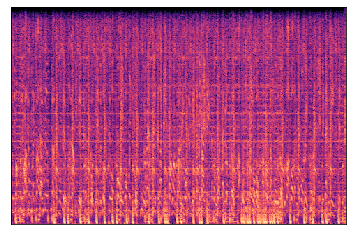

In [39]:
# generate spectrogram
D = librosa.amplitude_to_db(librosa.stft(x2), ref=np.max)
D.shape
d2 = scipy.ndimage.zoom(D, .125, order=0)
print(D.shape)
librosa.display.specshow(D)
#plt.specgram(x, NFFT=2048, Fs=2, Fc=0, noverlap=128, sides='default', mode='default', scale='dB');
#plt.axis('off');

(128, 480)


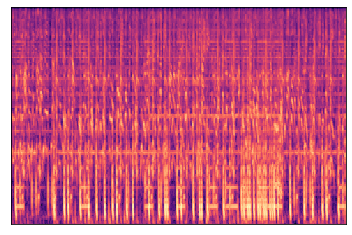

In [40]:
# generate mel spectrogram
spect = librosa.feature.melspectrogram(y=x2, sr=sr,n_fft=2048, hop_length=512)
D = librosa.power_to_db(spect, ref=np.max)
print(D.shape)
librosa.display.specshow(D)

In [41]:
def mel_spectrogram_from_id(track_id, ysize = 128, xsize = 128):
    if(track_id % 100 == 0):
        print(track_id)
    filename = fma_utils.get_audio_path(AUDIO_DIR, track_id)
    try:
        x, sr = librosa.load(filename, sr=None, mono=True)
    except:
        print(track_id)
        return
    
    sr2 = 8192
    x2 = librosa.core.resample(x, sr, sr2)
    spect = librosa.feature.melspectrogram(y=x2, sr=sr,n_fft=2048, hop_length=512)
    D = librosa.power_to_db(spect, ref=np.max)
    #d2 = scipy.ndimage.zoom(D, (1,1), order=0)
    d2=D
    padded = np.zeros((ysize, xsize))
    d3 = d2[:ysize, :xsize]
    padded[:d3.shape[0],:d3.shape[1]] = d3
    return padded

In [42]:
tracks['set subset'].unique()

array(['small', 'medium', 'large'], dtype=object)

In [43]:
# Get data from file system
# copied and modified from fma notebook

small = tracks['set subset'] == 'small' 
medium = tracks['set subset'].isin(['small','medium'])

train = tracks['set split'] == 'training'
val = tracks['set split'] == 'validation'
test = tracks['set split'] == 'test'

noterror = ~tracks['track_id'].isin([99134,108925,133297,1486,80391,98558,98559,98560,98571,105247,126981,127336,143992,65753])

y_train = tracks.loc[medium & train & noterror, ('track genre_top')]
y_val = tracks.loc[medium & val & noterror, ('track genre_top')]
y_train_onehot = pd.get_dummies(y_train)
y_val_onehot = pd.get_dummies(y_val)

ids_train = tracks.loc[medium & train & noterror, 'track_id']
ids_val = tracks.loc[medium & val & noterror, 'track_id']
X_train = np.reshape(np.stack(ids_train.apply(mel_spectrogram_from_id).values),(-1,128,256,1))
X_val = np.reshape(np.stack(ids_val.apply(mel_spectrogram_from_id).values),(-1,128,256,1))

np.save("FMA/x_train.npy",X_train)
np.save("FMA/x_val.npy",X_val)

print('{} training examples, {} val examples'.format(y_train.size, y_val.size))
print('{} features, {} classes'.format(X_train[0].shape, np.unique(y_train).size))

200
400
1900
4100
4300
4400
4700
4800
9800
10000
14100
14800
14900
16400
16700
17500
17900
18000
18200
20100
20200
21400
21800
24700
24800
25000
26600
28600
30500
32000
32800
32900
33200
33300
33500
36300
36400
38200
39900
40400
43600
44200
45100
47200
47500
47600
48400
48600
51200
52000
52500
53300
53900
55100
55200
55400
55900
56800
57400
57500
58600
60700
63100
63400
63500
63800
63900
64600
65000
66200
67000
67500
67600
68600
69200
71100
72200
72600
72700
73100
75900
76500
77400
78100
79000
81600
82900
83200
83400
83600
83900
84200
85400
86300
87100
87600
87700
88900
90800
91100
91300
91900
95200
95800
96400
96900
97400
97900
98800
99000
99300
99500
103600
103800
105400
105700
106700
107100
107500
107800
108300
108500
108800
109900
111400
112500
113300
113400
113600
113700
114200
114400
115700
116300


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\MadGe\Anaconda3\envs\tensorflow_gpuenv\lib\site-packages\pandas\core\series.py", line 3591, in apply
    mapped = lib.map_infer(values, f, convert=convert_dtype)
  File "pandas\_libs\lib.pyx", line 2217, in pandas._libs.lib.map_infer
  File "<ipython-input-41-b81fdc64d00c>", line 12, in mel_spectrogram_from_id
    x2 = librosa.core.resample(x, sr, sr2)
  File "C:\Users\MadGe\Anaconda3\envs\tensorflow_gpuenv\lib\site-packages\librosa\core\audio.py", line 293, in resample
    y_hat = resampy.resample(y, orig_sr, target_sr, filter=res_type, axis=-1)
  File "C:\Users\MadGe\Anaconda3\envs\tensorflow_gpuenv\lib\site-packages\resampy\core.py", line 113, in resample
    resample_f(x_2d, y_2d, sample_ratio, interp_win, interp_delta, precision)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\MadGe\Anaconda3\envs\tensorflow_gpuenv\lib\site-packages\IPytho

TypeError: must be str, not list

In [10]:
# OR
# load saved spectrograms
# copied and modified from fma notebook

small = tracks['set subset'] == 'small'
medium = tracks['set subset'].isin(['small','medium'])

train = tracks['set split'] == 'training'
val = tracks['set split'] == 'validation'
test = tracks['set split'] == 'test'

noterror = ~tracks['track_id'].isin([99134,108925,133297,1486,80391,98558,98559,98560,98571,105247,126981,127336,143992,65753])

y_train = tracks.loc[medium & train & noterror, ('track genre_top')]
y_val = tracks.loc[medium & val & noterror, ('track genre_top')]
y_train_onehot = pd.get_dummies(y_train)
y_val_onehot = pd.get_dummies(y_val)


ids_train = tracks.loc[medium & train & noterror, 'track_id']
ids_val = tracks.loc[medium & val & noterror, 'track_id']
X_train = np.load("FMA/x_train.npy")
X_val = np.load("FMA/x_val.npy")

print('{} training examples, {} val examples'.format(y_train.size, y_val.size))
print('{} features, {} classes'.format(X_train[0].shape, np.unique(y_train).size))

19909 training examples, 2504 val examples
(128, 256, 1) features, 16 classes


In [11]:
np.sum(y_train_onehot,axis=0)

Blues                    58
Classical               495
Country                 142
Easy Listening           13
Electronic             5048
Experimental           1800
Folk                   1214
Hip-Hop                1757
Instrumental           1044
International           814
Jazz                    306
Old-Time / Historic     408
Pop                     945
Rock                   5677
Soul-RnB                 94
Spoken                   94
dtype: int64

In [12]:
weights = .5+np.sum(y_train.size*y_train_onehot/(16*np.sum(y_train_onehot,axis=0)),axis=1)
weights.values

array([1.2082029 , 1.2082029 , 1.2082029 , ..., 1.52496911, 1.19128472,
       0.71918487])

In [19]:
input_shape = X_train[0].shape
num_classes = y_train_onehot.shape[-1]


modelCNN = keras.Sequential()

modelCNN.add(Conv2D(64, (8, 1), activation='relu', input_shape=input_shape, strides = (4,1)))
modelCNN.add(MaxPooling2D(pool_size=(2, 8)))
modelCNN.add(Conv2D(64, (4, 1), activation='relu'))
modelCNN.add(MaxPooling2D(pool_size=(2, 8)))
modelCNN.add(Flatten())
modelCNN.add(Dropout(.7))

modelCNN.add(Dense(256,  activation='relu'))

modelCNN.add(Dense(num_classes,  activation='softmax'))
modelCNN.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

history = modelCNN.fit(X_train/np.average(X_train), 
             y_train_onehot, 
             batch_size=32, 
             epochs=50, validation_data=(X_val/np.average(X_train), y_val_onehot),sample_weight=weights.values)

Train on 19909 samples, validate on 2504 samples
Epoch 1/50
19909/19909 [==============================] - 56s 3ms/step - loss: 4.1120 - acc: 0.2974 - val_loss: 2.4018 - val_acc: 0.2847
Epoch 2/50
19909/19909 [==============================] - 12s 619us/step - loss: 3.8876 - acc: 0.3477 - val_loss: 2.1341 - val_acc: 0.4361
Epoch 3/50
19909/19909 [==============================] - 12s 607us/step - loss: 3.6799 - acc: 0.3848 - val_loss: 2.0023 - val_acc: 0.4549
Epoch 4/50
19909/19909 [==============================] - 12s 594us/step - loss: 3.5989 - acc: 0.3933 - val_loss: 1.9900 - val_acc: 0.4377
Epoch 5/50
19909/19909 [==============================] - 12s 593us/step - loss: 3.5112 - acc: 0.3934 - val_loss: 1.9042 - val_acc: 0.4557
Epoch 6/50
19909/19909 [==============================] - 12s 588us/step - loss: 3.4276 - acc: 0.4015 - val_loss: 1.8797 - val_acc: 0.4269
Epoch 7/50
19909/19909 [==============================] - 12s 594us/step - loss: 3.4091 - acc: 0.4063 - val_loss: 1.885

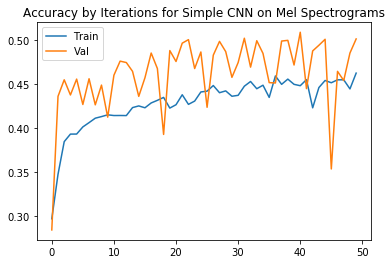

In [20]:
plt.plot(history.history['acc'], label ="Train")
plt.plot(history.history['val_acc'], label="Val")
plt.title("Accuracy by Iterations for Simple CNN on Mel Spectrograms")
plt.legend()
plt.show()

In [ ]:
# Run as needed
tf.keras.backend.clear_session()